In [1]:
import pandas as pd
import numpy as np
import datetime
%matplotlib inline
from yahoo_finance import Share
from googlefinance import getQuotes
import urllib.request as urlopen
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib as mpl
#import seaborn as sns
mpl.rcParams['figure.figsize'] = (14, 8)
#mpl.rc("figure.figsize",(14,8))

In [2]:
# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)    
plt.rcParams['axes.prop_cycle'] = mpl.cycler(color=tableau20) 
plt.rc('grid', linestyle="--", color='black',alpha = 0.5)

In [3]:
def GoogleIntradayQuote(Quotes,interval_seconds,num_days):
    df = pd.DataFrame(columns=['dt','stock','open','high','low','close','volume'])
    exchange = 'STO'
    for Quote in Quotes:
        url_string = "http://www.google.com/finance/getprices?q={0}&x={1}".format(Quote,exchange)
        url_string += "&i={0}&p={1}d&f=d,o,h,l,c,v".format(interval_seconds,num_days)
        csv = urlopen.urlopen(url_string).readlines()
        csv = [x.decode("utf-8") for x in csv]
        for bar in range(7,len(csv)):
            if csv[bar].count(',')!=5:
                continue
            offset,close,high,low,open_,volume = csv[bar].split(',')
            if offset[0]=='a':
                day = float(offset[1:])
                offset = 0
            else:
                offset = float(offset)
            open,high,low,close,volume = [float(x) for x in [open_,high,low,close,volume]]
            dt = datetime.datetime.fromtimestamp(day+(interval_seconds*offset)+60*60)
            df2 = pd.DataFrame([[dt,Quote,open,high,low,close,volume]],columns=['dt','stock','open','high','low','close','volume'])
            df = df.append(df2,ignore_index = True)
    return df, url_string

### Find suitable stocks for IDT

In [17]:
Quotes = ['HM-B','FING-B','NDA','VOLV-B','ATCO-B','SWED-A','SECU-B','HIQ','IJ','LUMI','SSAB-B']
df, url_string = GoogleIntradayQuote(Quotes,60*60,20)
df.head()

,dt,stock,open,high,low,close,volume
0,2017-01-18 09:00:00,HM-B,245.6,245.6,245.5,245.6,34915.0
1,2017-01-18 10:00:00,HM-B,245.6,246.6,245.1,246.3,250218.0
2,2017-01-18 11:00:00,HM-B,246.3,246.8,245.8,246.2,313794.0
3,2017-01-18 12:00:00,HM-B,246.1,246.7,245.6,246.6,167490.0
4,2017-01-18 13:00:00,HM-B,246.7,246.9,245.9,246.0,142209.0


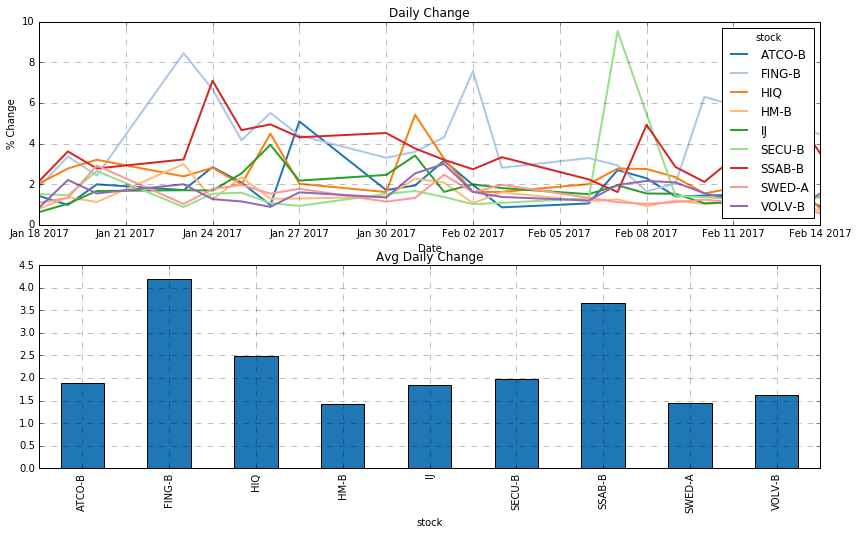

In [18]:
fig, ax = plt.subplots(2,1)
agg = {'high':'max','low':'min'}
df_daily_stock = df.groupby([df['dt'].dt.date,'stock']).agg(agg)
((df_daily_stock['high']/df_daily_stock['low']-1)*100).unstack(level=1).plot(ax = ax[0],legend=True,lw=2,grid='on',title='Daily Change')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('% Change')
((df_daily_stock['high']/df_daily_stock['low']-1)*100).groupby(level=1).mean().plot(ax = ax[1],kind='bar',grid='on',title='Avg Daily Change')

### Select single stock

In [16]:
Quote = ['FING-B']
interval_sec = 60*10
num_days = 200
df, url_string = GoogleIntradayQuote(Quote,interval_sec,num_days)
df.head()

,dt,stock,open,high,low,close,volume
0,2016-12-09 09:00:00,FING-B,66.20,66.20,66.20,66.20,174544.0
1,2016-12-09 09:10:00,FING-B,66.15,66.25,64.55,65.20,1459918.0
2,2016-12-09 09:20:00,FING-B,65.15,66.20,65.15,65.65,620107.0
3,2016-12-09 09:30:00,FING-B,65.70,65.95,65.50,65.65,403946.0
4,2016-12-09 09:40:00,FING-B,65.60,66.20,65.60,65.85,552621.0


In [15]:
print(url_string)
print(min(df['dt']))

http://www.google.com/finance/getprices?q=FING-B&x=STO&i=300&p=200d&f=d,o,h,l,c,v
2016-12-09 09:00:00


### Clean the data

In [21]:
df_daily = (
    df.groupby([df['dt'].dt.date,df['dt'].dt.time]).mean()
    .reset_index(level=0).rename(columns={'dt':'date'})
    .reset_index().rename(columns={'dt':'time'})
    .set_index(['time','date'])
    .unstack(level=1)
    )
ticks = len(df_daily.index)
days = len(df_daily['open'].columns)
ticks_thresh = round(ticks*0.1) #DROP DAYS WITH MORE THAN 10% MISSING VALUES
df_daily.dropna(thresh=ticks-ticks_thresh, axis=1,inplace=True)  #DROP DAYS WITH MORE THAN 10% MISSING VALUES
df_daily.bfill(inplace=True)
df_daily.ffill(inplace=True)
print('Days:\t\t',days)
days_used = len(df_daily['open'].columns)
print('Days droped:\t',days-days_used)
df_daily.head()

Days:		 50
Days droped:	 1


open                                                         \
date     2016-12-05 2016-12-06 2016-12-07 2016-12-08 2016-12-09 2016-12-12   
time                                                                         
09:00:00      77.00      75.35      73.65      64.65      66.20      63.50   
09:10:00      77.00      75.35      73.65      64.65      66.15      63.50   
09:20:00      76.30      75.10      73.05      64.70      65.15      62.60   
09:30:00      76.00      74.60      73.15      65.20      65.70      61.85   
09:40:00      75.95      74.30      73.65      65.90      65.60      61.35   

                                                        ...         volume  \
date     2016-12-13 2016-12-14 2016-12-15 2016-12-16    ...     2017-02-01   
time                                                    ...                  
09:00:00       57.5      61.70      58.40      59.00    ...       223381.0   
09:10:00       57.5      61.70      58.40      59.00    ...      1108130.0   
09:20:00       59.4      61.00      58.75      59.00    ...       802632.0   
09:30:00       60.2      60.45      59.20      58.70    ...       343806.0   
09:40:00       59.5      60.50      58.90      58.35    ...       523664.0   

                                                                            \
date     2017-02-02 2017-02-03 2017-02-06 2017-02-07 2017-02-08 2017-02-09   
time                                                                         
09:00:00  2591806.0  1361366.0   353504.0   927805.0   393426.0   260203.0   
09:10:00  2591806.0  1361366.0   353504.0   927805.0   393426.0   260203.0   
09:20:00  2608100.0   730209.0   356782.0   357694.0   178496.0   146911.0   
09:30:00   771083.0   404056.0   341625.0   300211.0   203903.0   569184.0   
09:40:00   777405.0   908893.0   120782.0   215089.0   148055.0   175336.0   

                                           
date     2017-02-10 2017-02-13 2017-02-14  
time                                       
09:00:00    17355.0   950747.0   375447.0  
09:10:00   207312.0   950747.0   375447.0  
09:20:00    88832.0   265843.0   148871.0  
09:30:00   392135.0   310516.0   352147.0  
09:40:00   400289.0   295482.0   454593.0  

[5 rows x 245 columns]

### Look at the data

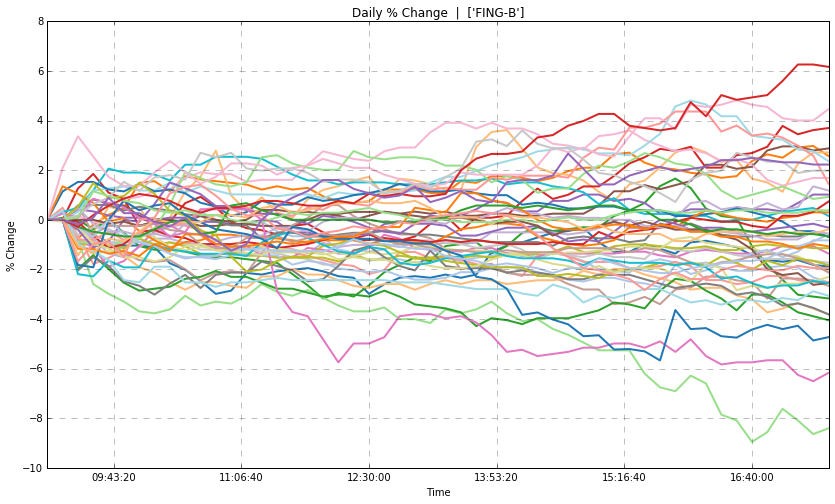

In [22]:
fig, ax = plt.subplots()
first_trade = df_daily.iloc[0,:]
df_daily_norm = (df_daily/first_trade-1)*100
df_daily_norm.loc[:,'high'].plot(ax = ax,legend=False,grid='on',title='Daily % Change  |  '+str(Quote), lw=2)
ax.set_xlabel('Time')
ax.set_ylabel('% Change')

In [23]:
labels = ['date','time','window','score']
score = pd.DataFrame(columns = ['date','time','window','score'])
for idx, col in df_daily_norm['high'].iteritems():
    score_part = pd.DataFrame(columns = ['date','time','window','score'])
    list = []
    for i in range(1,100):
        df_diff = col.diff(periods=i)
        list.append(dict(zip(labels,[col.name,df_diff.idxmax(),i,df_diff.max()])))
    #dd = dd.append(frame,ignore_index = True)
    frame = pd.DataFrame(list)
    score = score.append(frame,ignore_index = True)

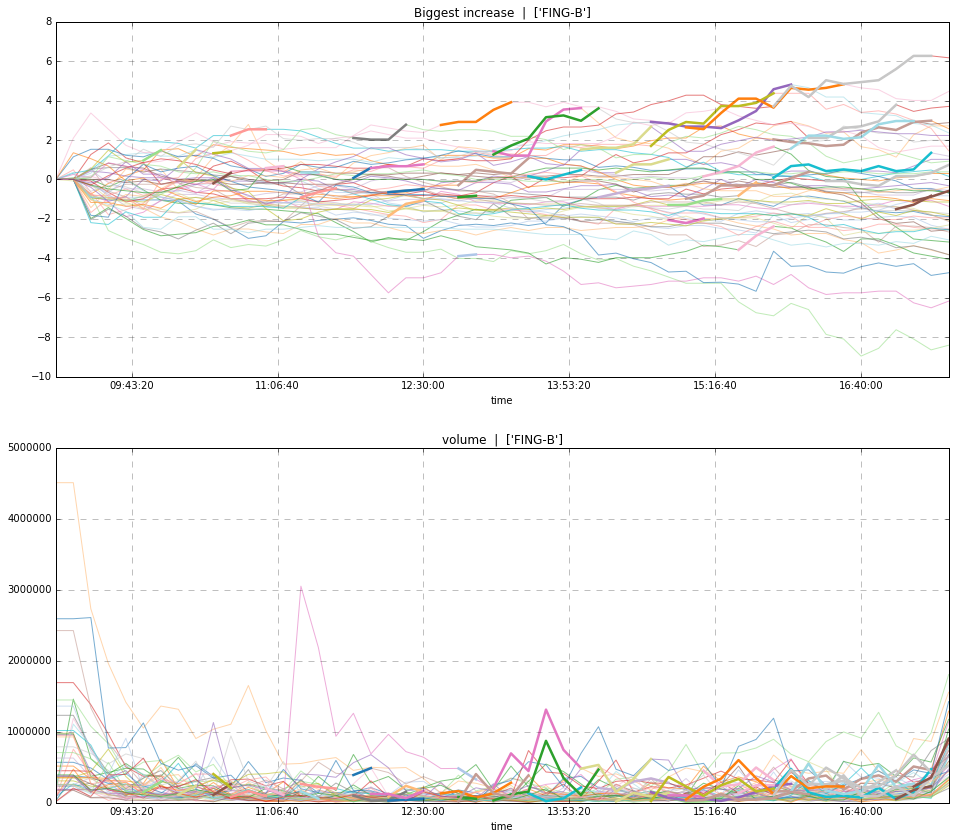

In [24]:
fig, ax = plt.subplots(2,1,figsize=(16,14))
top_increase = score.sort_values(by='score',ascending = False).groupby('date').head(1).sort_values(by='date')
df_daily_norm['high'].plot(ax=ax[0],legend=False,grid='on',alpha=0.6,title='Biggest increase  |  '+str(Quote),lw=1, ls='-')
df_daily['volume'].plot(ax=ax[1],legend=False,grid='on',title='volume  |  '+str(Quote),lw=1, ls='-',alpha=0.6)
counter = 0
for idx, row in top_increase.iterrows():
    delta = dt.timedelta(minutes=row['window']*2)
    start = (dt.datetime.combine(dt.date(1,1,1),row['time']) - delta).time()
    end = row['time']
    ax[0].plot(df_daily_norm['high'].loc[start:end,row['date']],lw=2.5)
    ax[1].plot(df_daily['volume'].loc[start:end,row['date']],lw=2.5)
    counter = counter+1

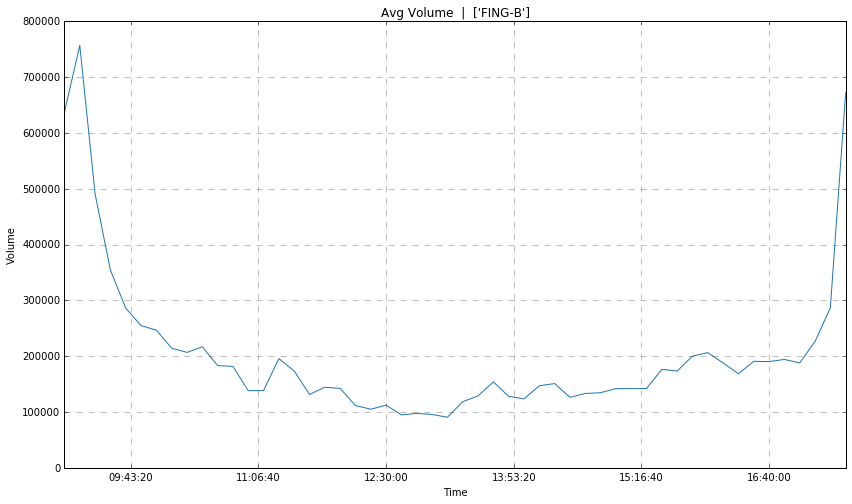

In [25]:
fig, ax = plt.subplots()
df_daily.loc[:,'volume'].mean(axis=1).plot(ax=ax,legend=False,grid='on',title='Avg Volume  |  '+str(Quote))
ax.set_xlabel('Time')
ax.set_ylabel('Volume')

### Extract Features

In [26]:
def doji(open,close,high,low):
    delta = 0.001
    d_t = 0.003
    lld_t = 0.01
    gd_t = 0.02
    dd_t = 0.02
    if (close<=open*(1+delta)) & (close>=open*(1-delta)) & (high>=(1+lld_t)*open) & (low<=(1-lld_t)*close):
        print('LONG LEGGED DOJI!')
        return 'll_doji'
    elif (close<=open*(1+delta)) & (close>=open*(1-delta)) & (high>=(1+d_t)*open) & (low<=(1-d_t)*close):
        print('DOJI!')
        return 'doji'
    elif (close<=open*(1+delta)) & (close>=open*(1-delta)) & (high>=(1+gd_t)*open) & (low<=(1+delta)*close) & (low>=(1-delta)*close):
        print('GRAVESTONE DOJI!')
        return 'g_doji'
    elif (close<=open*(1+delta)) & (close>=open*(1-delta)) & (low<=(1-dd_t)*open) & (high<=(1+delta)*close) & (high>=(1-delta)*close):
        print('DRAGONFLY DOJI!')
        return 'd_doji'
    else:
        return 'no_doji'

In [27]:
df_daily.stack(level=1).head()

open   high    low  close     volume
time     date                                             
09:00:00 2016-12-05  77.00  77.00  75.90  76.30   570122.0
         2016-12-06  75.35  75.35  74.65  75.15   256700.0
         2016-12-07  73.65  73.85  72.85  73.00   517076.0
         2016-12-08  64.65  66.35  61.90  64.60  4507496.0
         2016-12-09  66.20  66.20  66.20  66.20   174544.0

In [28]:
df_daily = df_daily.stack(level=1)
df_daily['doji'] = df_daily.apply(lambda row: doji(row['open'],row['close'],row['high'],row['low']), axis = 1)
df_daily = df_daily.unstack(level=1)

LONG LEGGED DOJI!
DOJI!
DOJI!
LONG LEGGED DOJI!
DOJI!
DOJI!
DOJI!
DOJI!
DOJI!
DOJI!
DOJI!
DOJI!
DOJI!
DOJI!
DOJI!
DOJI!
DOJI!
DOJI!
DOJI!
DOJI!
DOJI!


In [29]:
df_doji = df_daily.stack()['doji'][df_daily.stack()['doji']!='no_doji'].reset_index()
#df_doji = df_doji.reset_index(level=1).rename(columns={'dt':'date'}).reset_index().rename(columns={'dt':'time'})
df_doji

,time,date,doji
0,09:00:00,2016-12-08,ll_doji
1,09:00:00,2016-12-16,doji
2,09:00:00,2016-12-23,doji
3,09:10:00,2016-12-08,ll_doji
4,09:10:00,2016-12-16,doji
5,09:10:00,2016-12-23,doji
6,09:20:00,2017-02-02,doji
7,09:30:00,2016-12-19,doji
8,09:30:00,2017-01-12,doji
9,09:40:00,2016-12-14,doji


AttributeError: 'str' object has no attribute 'pop'

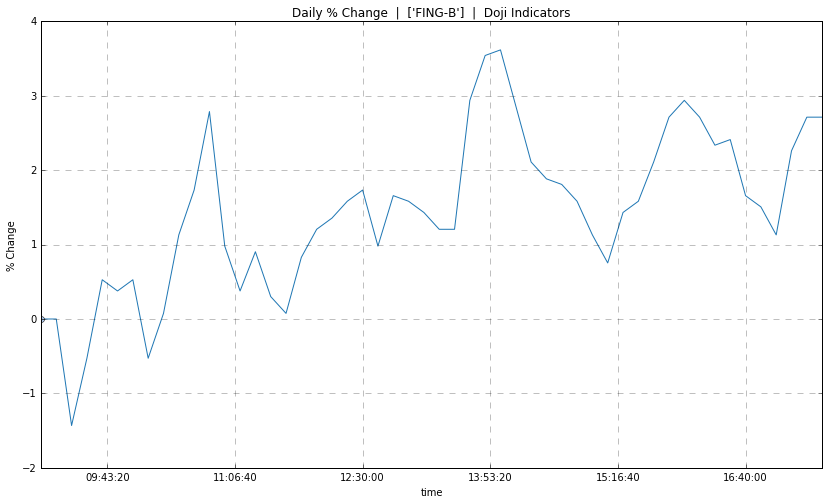

In [30]:
fig, ax = plt.subplots()
#df_daily_norm.loc[:,'high'].plot(ax = ax,legend=False,grid='on',title='Daily % Change  |  '+str(Quote))
ax.set_xlabel('Time')
ax.set_ylabel('% Change')
#print(df_daily_norm[df_doji[0,'time']])
for index, row in df_doji.iterrows():
    df_daily_norm['high'].loc[:,row['date']].plot(ax = ax,legend=False,grid='on',title='Daily % Change  |  '+str(Quote)+'  |  Doji Indicators')
    ax.plot(row['time'], df_daily_norm['high'].loc[row['time'],row['date']], 'o')
    if row['doji']!='doji':
        ax.text(row['time'], df_daily_norm['high'].loc[row['time'],row['date']], row['doji'], 'or', markersize=8)

              open      high       low     close     volume    spread  \
time                                                                    
09:00:00  0.000000  0.000000  0.000000  0.000000   0.000000  0.000000   
09:02:00  0.000000  0.000000  0.000000  0.000000   0.000000  0.000000   
09:04:00 -0.238663  0.000000  0.000000  0.159236 -28.066586  0.000000   
09:06:00  0.079554  0.000000 -0.318979 -0.159236  31.740589  0.318979   
09:08:00 -0.159109 -0.079428  0.000000 -0.079618 -23.494820 -0.079428   

          candlestick_body  
time                        
09:00:00          0.000000  
09:02:00          0.000000  
09:04:00         -0.397899  
09:06:00          0.238790  
09:08:00         -0.079491  


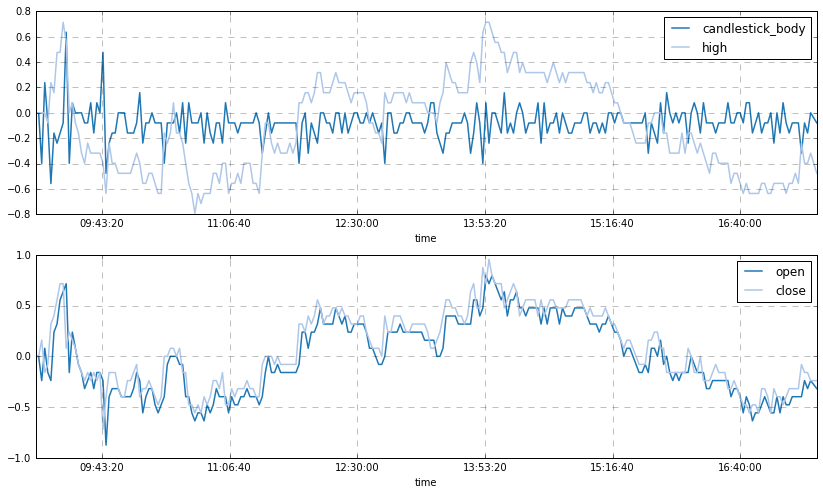

In [632]:
fig, ax = plt.subplots(2,1)
df_day_norm = df_daily_norm.unstack()[:,'2017-01-18',:].unstack(level=0)
df_day_norm['spread'] = df_day_norm['high'] - df_day_norm['low']
df_day_norm['candlestick_body'] = df_day_norm['open'] - df_day_norm['close']
df_day_norm['candlestick_body'].plot(ax=ax[0], legend=True)
df_day_norm['high'].plot(ax=ax[0], grid ='on', legend = True)
df_day_norm[['open','close']].plot(ax=ax[1], grid ='on', legend = True)
print(df_day_norm.head())
#.plot(secondary_y='volume')

In [261]:
df_features = pd.DataFrame()
df_features['close'] = round(df_daily_norm.loc[:,'high'].iloc[-1,:])
df_features['max'] = round(df_daily_norm.loc[:,'high'].max())
df_features['spread'] = round(df_daily_norm.loc[:,'high'].max()-df_daily_norm.loc[:,'high'].min())
df_features['volume'] = df_daily.loc[:,'volume'].mean(axis=0).rename('volume')
#df_features.append(df_daily.loc[:,'volume'].mean(axis=1)).head()
#df_features.append(df_daily.loc[:,'volume'].mean(axis=0).rename('volume'),axis=1)
df_features.head()

,close,max,spread,volume
dt,,,,
2016-12-22,-3.0,0.0,3.0,14763.893701
2016-12-29,-2.0,0.0,2.0,10419.996063
2016-12-30,1.0,1.0,3.0,12505.433071
2017-01-02,0.0,1.0,2.0,11768.480315
2017-01-03,1.0,1.0,2.0,14400.314961


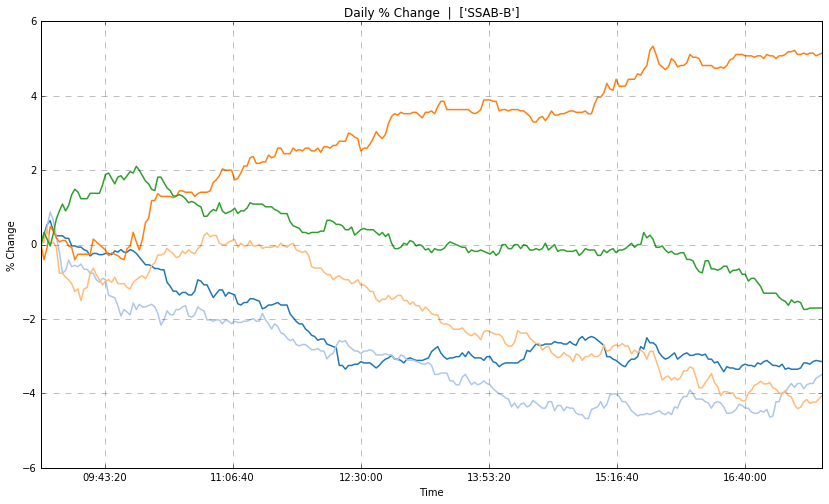

In [274]:
# Look at days with specific feature
fig, ax = plt.subplots()
df_daily_norm.loc[:,'high'].T[df_daily_norm['high'].columns.isin(df_features[df_features['spread']>=4].index)].T.plot(ax = ax,legend=False,grid='on',title='Daily % Change  |  '+str(Quote))
ax.set_xlabel('Time')
ax.set_ylabel('% Change')

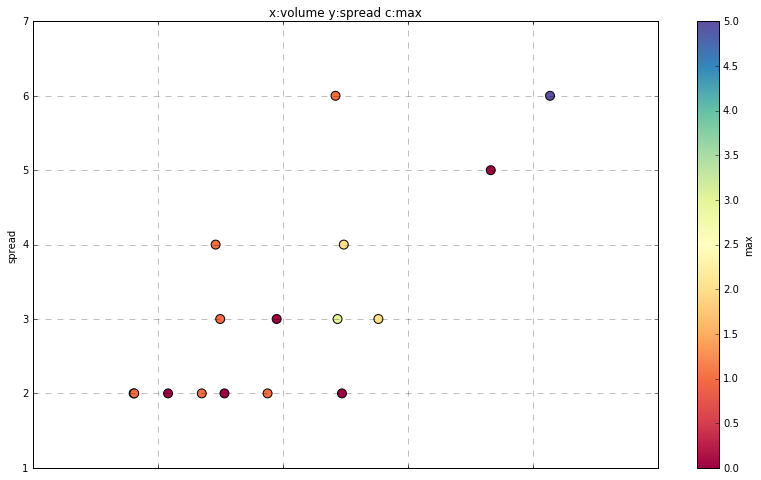

In [285]:
cmap = mpl.cm.get_cmap('Spectral')
x = 'volume'
y = 'spread'
c = 'max'
df_features.plot(kind='scatter',x=x,y=y,c=c,cmap=cmap,s=80,grid='on',title='x:'+x+' y:'+y+' c:'+c)